# Introduction:

We will be working with a dataset composed of images of hands making a number in different positions, our goal is to be able via an image of a hand indicationg a certain number to recognize that number with a good level of accuracy. 

This will help make machines more sign language friendly. You can find the dataset used for this tutorial in the following link:

https://www.kaggle.com/koryakinp/fingers

The dataset contains 21600 128x128 images of hands making a number sign. 
The train data contains 18000 images and the test data contains 3600 images.

But before getting into business let's do a little warm-up with Tensorflow and explore its main functionalities.

In [180]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd

## Tensorflow quick initialization:

We will use tensorflow in the next section to calculate usual stuff we calculate in ML (Initialization, cost function, etc..) using the tensorflow framework to get used to it. This is not an attempt to reinvent the wheel (since Tensorflow contains functions that does most of the ML model building, training and testing tasks), but seems like a good way to get used to the dataflow pradigm. So without further ado let's get into it: 

In [181]:
# We'll start by implementing the square difference loss function. 

y_hat = tf.constant(36, name='y_hat')            # y_hat Set to 36.
y = tf.constant(39, name='y')                    # y Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss

init = tf.global_variables_initializer()         # Creates an initaializer to be run in the session.
                                                 # By defining the variables and operations to do we are creating
                                                 # a computation graph, this latter can be computed fully or partially using
                                                 # a Tensorflow session.
            
with tf.Session() as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))                     # Prints the loss

9


To sum it up:
Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated.
2. Write operations between those Tensors.
3. Initialize your Tensors.
4. Create a Session.
5. Run the Session. This will run the operations you'd written above.


Next, we'll introduce placeholders. A placeholder is an object whose value you can specify only later. To specify values for a placeholder, you can pass in values by using a "feed dictionary" (feed_dict variable).

In [182]:
# Example: This is generally used for creating a holder for the training data batches later on, also to initialize the models
# hyperparameters: learning rate, keep_prob, etc...

x = tf.placeholder(tf.int64, name = 'x')
sess=tf.Session()
print(sess.run(2 * x, feed_dict = {x: 3}))
sess.close()

6


Okay, now let's use Tensorflow powerfull tools to do this mini computer-vision project.

In [183]:
input_file = "C:/Users/YsfEss/Desktop/train_signs.h5"
with h5py.File(input_file,'r') as hdf:
    ls=list(hdf.keys())
    xl=hdf.get('train_set_x')
    yl=hdf.get('train_set_y')
    cl=hdf.get('list_classes')
    imgs=np.array(xl)
    labels=np.array(yl)
    classes=np.array(cl)
print(ls)
print(imgs.shape,labels.shape,classes.shape)

['list_classes', 'train_set_x', 'train_set_y']
(1080, 64, 64, 3) (1080,) (6,)


5


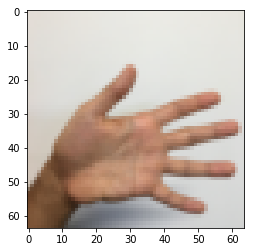

In [184]:
index=0
print(classes[labels[index]])
plt.imshow(imgs[index])

In [68]:
n=imgs.shape[0] # Number of observations.
p=imgs.shape[1]*imgs.shape[2]*imgs.shape[3] # Number of attributes/features.
data=imgs.reshape(n,p)
TrData=pd.DataFrame(data=data)
# Neural network means we have to normalize our data by deviding each entry by 255.
TrData=TrData.applymap(lambda x:x/255)
labels=pd.DataFrame(data=labels,columns=['CLASS'])
TrData=pd.concat([TrData,labels],axis=1)
TrData.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,CLASS
0,0.890196,0.862745,0.839216,0.890196,0.866667,0.843137,0.890196,0.870588,0.843137,0.890196,...,0.819608,0.823529,0.823529,0.819608,0.823529,0.819608,0.815686,0.819608,0.819608,5
1,0.933333,0.909804,0.874510,0.933333,0.909804,0.874510,0.933333,0.909804,0.874510,0.929412,...,0.839216,0.796078,0.760784,0.843137,0.796078,0.760784,0.843137,0.800000,0.752941,0
2,0.894118,0.862745,0.815686,0.894118,0.862745,0.815686,0.890196,0.858824,0.815686,0.890196,...,0.815686,0.800000,0.784314,0.823529,0.807843,0.788235,0.827451,0.811765,0.792157,2
3,0.894118,0.858824,0.815686,0.898039,0.858824,0.815686,0.894118,0.862745,0.815686,0.890196,...,0.780392,0.760784,0.760784,0.784314,0.764706,0.756863,0.788235,0.768627,0.756863,5
4,0.882353,0.850980,0.800000,0.882353,0.854902,0.803922,0.882353,0.854902,0.807843,0.882353,...,0.803922,0.792157,0.788235,0.792157,0.780392,0.776471,0.780392,0.764706,0.752941,2


 Train data done and dusted, now for the test dataset. 

In [70]:
input_file = "C:/Users/YsfEss/Desktop/test_signs.h5"
with h5py.File(input_file,'r') as hdf1:
    ls1=list(hdf1.keys())
    xl1=hdf1.get('test_set_x')
    yl1=hdf1.get('test_set_y')
    cl1=hdf1.get('list_classes')
    imgs1=np.array(xl1)
    labels1=np.array(yl1)
    classes=np.array(cl1)
print(imgs1.shape,labels1.shape,classes.shape)

(120, 64, 64, 3) (120,) (6,)


In [71]:
tdata=imgs1.reshape(imgs1.shape[0],imgs1.shape[1]*imgs1.shape[2]*imgs1.shape[3])
teD=pd.DataFrame(data=tdata)
testD=teD.applymap(lambda x: x/255)
labelsT=pd.DataFrame(data=labels1,columns=['CLASS'])
teData=pd.concat([testD,labelsT],axis=1)
teData.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,CLASS
0,0.905882,0.878431,0.847059,0.909804,0.878431,0.847059,0.909804,0.882353,0.850980,0.909804,...,0.850980,0.800000,0.764706,0.854902,0.800000,0.764706,0.850980,0.800000,0.756863,0
1,0.905882,0.874510,0.843137,0.905882,0.874510,0.843137,0.909804,0.878431,0.847059,0.909804,...,0.713725,0.650980,0.607843,0.705882,0.639216,0.588235,0.690196,0.623529,0.564706,0
2,0.901961,0.878431,0.847059,0.901961,0.878431,0.847059,0.901961,0.878431,0.847059,0.898039,...,0.819608,0.772549,0.737255,0.819608,0.776471,0.737255,0.819608,0.776471,0.733333,0
3,0.913725,0.890196,0.858824,0.913725,0.894118,0.858824,0.913725,0.890196,0.858824,0.909804,...,0.258824,0.250980,0.250980,0.094118,0.101961,0.125490,0.078431,0.090196,0.113725,5
4,0.886275,0.854902,0.823529,0.890196,0.854902,0.823529,0.886275,0.858824,0.823529,0.886275,...,0.792157,0.788235,0.784314,0.792157,0.788235,0.784314,0.792157,0.788235,0.784314,1


This problem is very similar to the one done on the Cat Vs. Not cat project. The only difference is that in this case we have multiple outputs possible. So, we will be using softmax output instead. 

So the model that will be used is the following: (2 hidden layers 25 units in first and 12 in second) INPUT -> RELU -> RELU -> SOFTMAX. 

In [98]:
# First, let's create placeholders for X and Y. That will be used for training later on. 

def createPlaceholder(n_x,n_y):
    X=tf.placeholder(dtype=tf.float32,shape=[n_x,None],name='X')
    Y=tf.placeholder(dtype=tf.float32,shape=[n_y,None],name='Y')
    return(X,Y)

In [127]:
def intializePar():
    W1=tf.get_variable(name='W1',shape=[25, 12288],initializer = tf.contrib.layers.xavier_initializer()) # Xavier intilization helps with stability of variance of inputs/outputs through each layers, in the grand scheme of avoiding exploding/vanishing gradients.
    b1=tf.get_variable(name='b1',shape=[25, 1],initializer = tf.contrib.layers.xavier_initializer())
    W2=tf.get_variable(name='W2',shape=[12, 25],initializer = tf.contrib.layers.xavier_initializer())
    b2=tf.get_variable(name='b2',shape=[12, 1],initializer = tf.contrib.layers.xavier_initializer())
    W3=tf.get_variable(name='W3',shape=[6, 12],initializer = tf.contrib.layers.xavier_initializer())
    b3=tf.get_variable(name='b3',shape=[6, 1],initializer = tf.contrib.layers.xavier_initializer())
    parameters={'W1':W1,
                'b1':b1,
                'W2':W2,
                'b2':b2,
                'W3':W3,
                'b3':b3}
    return(parameters)

So we will now start with the learning process, first of all forward propagation.

In [135]:
def forward_prop(X,parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    

    Z1 = tf.add(tf.matmul(W1,X),b1) 
    A1 = tf.nn.relu(Z1) 
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                               
    
    return Z3

Now we will implement the cost function.

In [107]:
def compute_cost(Z3, Y):
    
    predicted = tf.transpose(Z3)
    real = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted,labels=real))
    
    return cost

In [136]:
# Create the mini batches
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y)
    num_minibatches = math.floor(m/mini_batch_size) # Returns larger integer that is inferior or equal to m/mini_batch_size.
    for k in range(0, num_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Finally, Backpropagation and parameters update.

In [186]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,num_epochs = 1500, minibatch_size = 32):
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x,None and n_y,None) None means any size this usefull since we want to use mini-batch optimization.
    X, Y = createPlaceholder(n_x,n_y)

    # Parameters initialization
    parameters = intializePar()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_prop(X,parameters)
    
    cost = compute_cost(Z3,Y)
    
    # Backpropagation: Define the tensorflow optimizer. We will use Adam optimizer for this problem.
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
   
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every 100 epoch
            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5==0:
                costs.append(epoch_cost)
                
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y)) # The output is one hot vector so the index of 1 must match the labels for correct predcitons

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train})) # Seems like magic but well, that's Tensorflow
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))  # Calling this method eval will execute all preceding operations 
                                                                        #that produce the inputs needed for the operation that
                                                                        #produces this tensor.
                                                                        #Caution: The feed must not be a Tf tensor instead a numpy array.
        
        return parameters

In [187]:
X_train=TrData.loc[:, TrData.columns != 'CLASS'].T.to_numpy()
Y_train=TrData.loc[:, TrData.columns=='CLASS'].T.to_numpy()
X_test=teData.loc[:, teData.columns != 'CLASS'].T.to_numpy()
Y_test=teData.loc[:, teData.columns=='CLASS'].T.to_numpy()

In [189]:
# Caution: You must before starting training make sure that your outputs are 0ne_hot coded.
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [190]:
Y_train=convert_to_one_hot(Y_train,6)
Y_test=convert_to_one_hot(Y_test,6)

Cost after epoch 0: 1.956510
Cost after epoch 100: 1.093006
Cost after epoch 200: 0.793944
Cost after epoch 300: 0.600231
Cost after epoch 400: 0.439077
Cost after epoch 500: 0.330592
Cost after epoch 600: 0.234940
Cost after epoch 700: 0.171177
Cost after epoch 800: 0.124197
Cost after epoch 900: 0.082712
Cost after epoch 1000: 0.070395
Cost after epoch 1100: 0.038022
Cost after epoch 1200: 0.025601
Cost after epoch 1300: 0.026190
Cost after epoch 1400: 0.012433


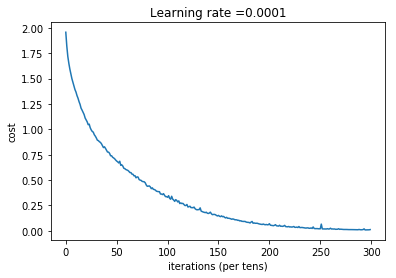

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.75


In [191]:
parameters = model(X_train, Y_train, X_test, Y_test)

Seems like a good test accuracy for a shallow neural network, we can further tune the hyperparameters and also use other regularization techniques such as drop out and find better models.